<a href="https://colab.research.google.com/github/Hamzakhan2005/ML-Practice/blob/main/Fake%20News%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk scikit-learn keras tensorflow

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
  0% 0.00/41.0M [00:00<?, ?B/s]
100% 41.0M/41.0M [00:00<00:00, 957MB/s]


In [ ]:
import zipfile
import os

# Unzip
with zipfile.ZipFile("fake-and-real-news-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("news_data")

# Check contents
os.listdir("news_data")


['True.csv', 'Fake.csv']

In [ ]:
import pandas as pd

fake_df = pd.read_csv("news_data/Fake.csv")
true_df = pd.read_csv("news_data/True.csv")

# Check
print("Fake shape:", fake_df.shape)
print("True shape:", true_df.shape)


Fake shape: (23481, 4)
True shape: (21417, 4)


In [ ]:

# Add labels: 0 for Fake, 1 for True
fake_df['label'] = 0
true_df['label'] = 1

# Merge both datasets
df = pd.concat([fake_df, true_df], ignore_index=True)
df = df[['text', 'label']]  # use only the text and label columns
df = df.dropna()  # remove any rows with missing values


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
ps = PorterStemmer()

def preprocess(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if word not in stopwords.words('english')]
    return ' '.join(text)

df['cleaned_text'] = df['text'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text']).toarray()
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Results:
Accuracy: 0.9867483296213808
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4733
           1       0.98      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Results:
Accuracy: 0.994097995545657
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4733
           1       0.99      1.00      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Results:
Accuracy: 0.9252783964365257
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4733
           1       0.93      0.91      0.92      4247

    accuracy                           0.93      8980
   macro avg       0.93      0.92      0.92      8980
weighted avg       0.93      0.93      0.93      8980



In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Predict and evaluate
y_pred_nn = model.predict(X_test)
y_pred_nn = (y_pred_nn > 0.5).astype(int).flatten()

print("Neural Network Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9165 - loss: 0.2368 - val_accuracy: 0.9872 - val_loss: 0.0364
Epoch 2/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9947 - loss: 0.0187 - val_accuracy: 0.9889 - val_loss: 0.0332
Epoch 3/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9989 - loss: 0.0060 - val_accuracy: 0.9919 - val_loss: 0.0321
Epoch 4/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 0.9894 - val_loss: 0.0406
Epoch 5/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9903 - val_loss: 0.0407
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Neural Network Results:
Accuracy: 0.9910913140311804
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4733
           1       0.99      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99 

In [ ]:
results = {
    'Model': ['Logistic Regression', 'SVM', 'Naive Bayes', 'Neural Network'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_nn)
    ]
}

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy
0  Logistic Regression  0.986748
1                  SVM  0.994098
2          Naive Bayes  0.925278
3       Neural Network  0.991091


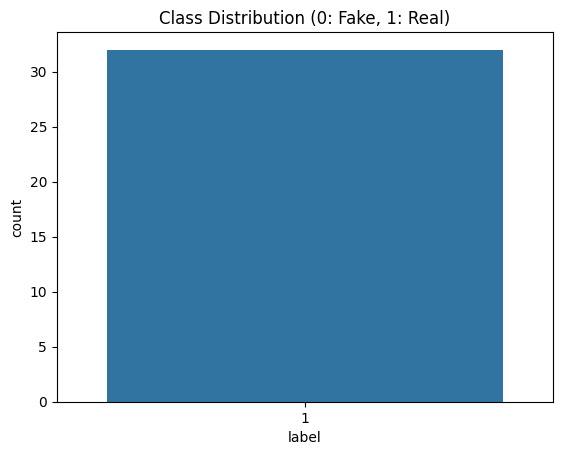

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['label'])
plt.title("Class Distribution (0: Fake, 1: Real)")
plt.show()


In [ ]:
from wordcloud import WordCloud

# Fake news word cloud
fake_text = ' '.join(fake_df['text'].dropna())
wordcloud_fake = WordCloud(width=800, height=400).generate(fake_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title("WordCloud - Fake News")
plt.axis("off")
plt.show()

# Real news word cloud
real_text = ' '.join(true_df['text'].dropna())
wordcloud_real = WordCloud(width=800, height=400).generate(real_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title("WordCloud - Real News")
plt.axis("off")
plt.show()


KeyboardInterrupt: 

In [ ]:
import requests

api_key = '9c7a7425c9d1406ba2eae4263878159b'  # Replace with your actual key
url = f'https://newsapi.org/v2/top-headlines?language=en&apiKey={api_key}&pageSize=100'

response = requests.get(url)
data = response.json()

print(f"Total articles fetched: {len(data['articles'])}")

if len(data['articles']) > 0:
    articles = []
    for article in data['articles']:
        text = f"{article.get('title', '')} {article.get('description', '')} {article.get('content', '')}".strip()
        if text:
            articles.append({'text': text, 'label': 1})

    import pandas as pd
    df = pd.DataFrame(articles)
    df.to_csv("real_news_from_api.csv", index=False)
    print("Saved real news to CSV.")
else:
    print("No articles returned. Try changing the API query or check your key.")


Total articles fetched: 32
Saved real news to CSV.


In [ ]:
import requests
import pandas as pd

# Replace with your NewsAPI key
api_key = '9c7a7425c9d1406ba2eae4263878159b'
url = ('https://newsapi.org/v2/top-headlines?'
       'country=in&'
       'pageSize=100&'
       f'apiKey={api_key}')

response = requests.get(url)
data = response.json()
print(data.keys())           # Should include 'articles'
print(len(data['articles'])) # Number of articles fetched
# print(data['articles'][0])   # Show first article dictionary

# articles = data['articles']

# # Convert to DataFrame
# news_df = pd.DataFrame(articles)
# news_df = news_df[['title', 'description', 'content']].dropna()
# news_df['text'] = news_df['title'] + ' ' + news_df['description'] + ' ' + news_df['content']
# news_df = news_df[['text']]
# news_df['label'] = 1  # real news

# news_df.head()


dict_keys(['status', 'totalResults', 'articles'])
0
